#  **1. Loading Libraries**

In [39]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook,tqdm
import torch.optim as optim
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
#Setting the seed
seed=2009
torch.manual_seed(seed)

## **2. Loading Datatset**

In [3]:
#Reading the file
with open('/content/wiki.train.tokens','r') as t:
  text=t.readlines()

In [4]:
#Let's check the length
len(text)

36718

So we have 36k lines

In [5]:
#Let's look at few lines
text[0:5]

[' \n',
 ' = Valkyria Chronicles III = \n',
 ' \n',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> f

Lots of unclean data

# **3. Preprocessing the data**

In [6]:
def cleaner(text):

   data=[]
   for sentence in text:
    # Convert text to lowercase
    sentence = sentence.lower()

    # Remove non-numeric characters (retains only letters and spaces)
    sentence = re.sub(r"[^a-zA-Z' ]", '', sentence)

    # Remove unk
    sentence = re.sub(r'\bunk\b', '', sentence)

    #Remove extra space
    sentence = re.sub(r"[\s]+", ' ', sentence)

    #Trim the extra space
    sentence = sentence.strip()

    data.append(sentence)

   return [output for output in data if output.strip()]

In [7]:
cleaned_text=cleaner(text)

In [8]:
cleaned_text[:5]

['valkyria chronicles iii',
 'senj no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed by sega and mediavision for the playstation portable released in january in japan it is the third game in the valkyria series the same fusion of tactical and real time gameplay as its predecessors the story runs parallel to the first game and follows the nameless a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit raven',
 "the game began development in carrying over a large portion of the work done on valkyria chronicles ii while it retained the standard features of the series it also underwent multiple adjustments such as making the game more for series newcomers character designer honjou and composer hitoshi sakimoto both returned from previous entries along with valkyria c

In [9]:
len(cleaned_text)

23335

# **4. Let's create vocablury**

In [10]:
#Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
x_tokenizer=Tokenizer()

In [12]:
# Fitting on the clean data
x_tokenizer.fit_on_texts(cleaned_text)

In [13]:
len(x_tokenizer.word_counts)

27305

We have 27k words

In [14]:
# Let's check min word_count
min(x_tokenizer.word_counts.values())

3

In [15]:
#Let's pull out words with atleast 4 occurences
ct=0
freq=4
for key,value in x_tokenizer.word_counts.items():
  if value>=freq:
    ct+=1
print(ct)

22480


In [16]:
#Tokenizing with 4 or more occurence words and rest as unknown_1
x_tokenizer = Tokenizer(num_words=ct,oov_token='unkown_1')
x_tokenizer.fit_on_texts(cleaned_text)

In [17]:
#Let's Check the length of words in the sequence of dialogs
def word_ct(text):
  sequence_ct=[]
  for sentence in text:
    sequence_ct.append(len(sentence))
  return sequence_ct

Median count is 360.0
Mode count is 7


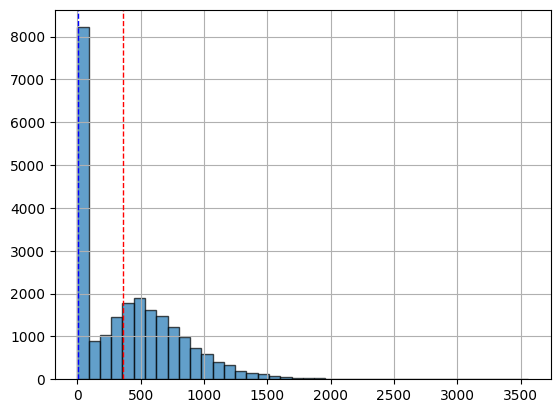

In [18]:
sequence=word_ct(cleaned_text)
median_count = pd.Series(sequence).median()
mode_count = pd.Series(sequence).mode()[0]
pd.Series(sequence).hist(bins=40,edgecolor='black', alpha=0.7)
plt.axvline(median_count, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_count}')
plt.axvline(mode_count, color='blue', linestyle='dashed', linewidth=1, label=f'Mode: {mode_count}')
print("Median count is",median_count)
print("Mode count is",mode_count)

# **4. Padded Sequence**

In [19]:
#Let's first create a sequence of  words so we could then create x_tr as 21 words
def word_seq(text,seq_len):

  # Create a list to store the sequences
  sequences = []

  if len(text.split())>seq_len:
    words = text.split()

    # Loop through the words and create sequences of the specified length
    for i in range(seq_len, len(words)):
      sequence = ' '.join(words[i-seq_len:i+1])
      sequences.append(sequence)
    return (sequences)
  else:
    return [text]

In [20]:
seq_length=21
line_sequence = [word_seq(sentence, seq_length) for sentence in tqdm(cleaned_text, desc="Processing Sequences")]

Processing Sequences: 100%|██████████| 23335/23335 [00:01<00:00, 14588.60it/s]


In [21]:
cleaned_text[1]

'senj no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed by sega and mediavision for the playstation portable released in january in japan it is the third game in the valkyria series the same fusion of tactical and real time gameplay as its predecessors the story runs parallel to the first game and follows the nameless a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit raven'

In [22]:
line_sequence[0:2]

[['valkyria chronicles iii'],
 ['senj no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical',
  'no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role',
  'valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing',
  'chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video',
  'japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game',
  'lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed',
  'valkyria of the battlefield commonly referred to as valkyria chroni

In [23]:
#Making one master_list
unpadded_sequence_master = sum(tqdm(line_sequence, desc="Summing Sequences"), [])


Summing Sequences: 100%|██████████| 23335/23335 [09:18<00:00, 41.82it/s]


In [24]:
unpadded_sequence_master[:4]

['valkyria chronicles iii',
 'senj no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical',
 'no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role',
 'valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing']

In [ ]:
len(unpadded_sequence_master)

In [25]:
#Breaking into input and target sequences
x=[]
y=[]
for s in unpadded_sequence_master:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [38]:
# Let's check the i/p o/p sequences
x[1],y[1]

('senj no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a',
 'no valkyria chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical')

# **Train test split**

In [27]:
#Train test split
split=int(len(x)*0.7)
x_train=x[:split]
x_test=x[split:]

y_train=y[:split]
y_test=y[split:]

# **Text to Integer Sequences**

In [28]:
#Converting text to integer sequences
x_train_sequence=x_tokenizer.texts_to_sequences(x_train)
x_test_sequence=x_tokenizer.texts_to_sequences(x_test)
y_train_sequence=x_tokenizer.texts_to_sequences(y_train)
y_test_sequence=x_tokenizer.texts_to_sequences(y_test)

In [34]:
#Creating padded sequence
x_train_sequence_padded=pad_sequences(x_train_sequence,padding='post',maxlen=21)
y_train_sequence_padded=pad_sequences(y_train_sequence,padding='post',maxlen=21)

x_test_sequence_padded=pad_sequences(x_test_sequence,padding='post',maxlen=21)
y_test_sequence_padded=pad_sequences(y_test_sequence,padding='post',maxlen=21)

In [80]:
#Including teh padded sequence in the vocab
vocab_size=x_tokenizer.num_words+1

In [37]:
#Let's check the shape
x_train_sequence_padded.shape,x_test_sequence_padded.shape,y_train_sequence_padded.shape,y_test_sequence_padded.shape

((913284, 21), (391408, 21), (913284, 21), (391408, 21))

In [96]:
#Convert to array
x_train_sequence_padded=np.array(x_train_sequence_padded[:10000,:])
y_train_sequence_padded=np.array(y_train_sequence_padded[:10000,:])
x_test_sequence_padded=np.array(x_test_sequence_padded[:10000,:])
y_test_sequence_padded=np.array(y_test_sequence_padded[:10000,:])

In [97]:
#Let's check the shape
x_train_sequence_padded.shape,x_test_sequence_padded.shape,y_train_sequence_padded.shape,y_test_sequence_padded.shape

((10000, 21), (10000, 21), (10000, 21), (10000, 21))

In [98]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        x = self.embedding(x)
        x, h = self.gru(x, h)
        x = x.reshape(-1, self.hidden_size)
        x = self.dropout(x)
        x = self.fc(x)  # Take the output of the last time step
        return x, h

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Parameters
embedding_dim = 128
hidden_size = 256
num_layers = 2
output_size = vocab_size  # Predicting the next word, so output size is vocab size
dropout_prob = 0.5

# Initialize the model
net = GRUModel(vocab_size, embedding_dim, hidden_size, num_layers, output_size, dropout_prob)


In [99]:
print(net)

GRUModel(
  (embedding): Embedding(22481, 128)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=22481, bias=True)
)


In [100]:
def get_batches(arr_x,arr_y,batch_size):
  prv=0
  for n in range(batch_size,arr_x.shape[0],batch_size):
    x=arr_x[prv:n,:]
    y=arr_y[prv:n,:]
    prv=n
    yield x,y

In [101]:
def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
    best_valid_loss = float('inf')

    # Optimizer
    opt = torch.optim.Adam(net.parameters(), lr=lr)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    counter = 0
    net.train()

    for e in range(epochs):
        h = net.init_hidden(batch_size)

        for x, y in tqdm(get_batches(x_train_sequence_padded, y_train_sequence_padded, batch_size)):
            counter += 1

            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.long()

            h = h.detach()  # Detach hidden state to prevent backprop through entire training history
            net.zero_grad()

            output, h = net(inputs, h)
            loss = criterion(output, targets.view(-1))
            loss.backward()
            opt.step()

            if counter % print_every == 0:
                val_losses = []
                net.eval()

                with torch.no_grad():
                    for x_val, y_val in get_batches(x_test_sequence_padded, y_test_sequence_padded, batch_size):
                        x_val, y_val = torch.from_numpy(x_val), torch.from_numpy(y_val)
                        y_val = y_val.long()

                        val_h = net.init_hidden(batch_size)
                        output_val, val_h = net(x_val, val_h)
                        val_loss = criterion(output_val, y_val.view(-1))
                        val_losses.append(val_loss.item())

                avg_val_loss = np.mean(val_losses)
                if avg_val_loss < best_valid_loss:
                    best_valid_loss = avg_val_loss
                    torch.save(net.state_dict(), 'saved_weights.pt')

                net.train()

                print(f"Epoch: {e+1}/{epochs}, Step: {counter}, Loss: {loss.item()}, Val_loss: {avg_val_loss}")


In [ ]:
# Training the model
batch_size = 32
train(net, batch_size=batch_size, epochs=1)

19it [00:22,  1.19it/s]

In [123]:
path= 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [124]:
word_index = x_tokenizer.word_index
reverse_word_index = {index: word for word, index in word_index.items()}

In [125]:
def predict(net,token,h=None):
  x=np.array([[x_tokenizer.word_index[token]]])
  input=torch.from_numpy(x)
  print(input)
  out,h=net(input,h)
  print(out)
  p=F.softmax(out,dim=1).data
  p=p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]
  print()
  b=reverse_word_index.get(sampled_token_index)
  print(b)
  return b,h

In [126]:
def sample(net,size=2,seed_text='game developed'):
  net.eval()
  h=net.init_hidden(1)
  toks=seed_text.split()
  for t in toks:
    print (t)
    token,h=predict(net,t,h)
  toks.append(token)
  print("Here is toks")
  print(toks)
  for i in range(size-1):
    token,h=predict(net,toks[-1],h)
    toks.append(token)
  return ' '.join(toks)

In [127]:
sample(net,4)

game
tensor([[60]])
tensor([[-0.8081,  0.1196,  0.8141,  ..., -3.5712, -3.3532, -3.3966]],
       grad_fn=<AddmmBackward0>)

's
developed
tensor([[406]])
tensor([[-2.1674,  0.6015,  1.1629,  ..., -5.4145, -5.2029, -5.3338]],
       grad_fn=<AddmmBackward0>)

the
Here is toks
['game', 'developed', 'the']
tensor([[2]])
tensor([[-2.0846,  1.3743, -1.6246,  ..., -3.7618, -3.5509, -3.7788]],
       grad_fn=<AddmmBackward0>)

blue
tensor([[622]])
tensor([[-0.8750,  0.6295,  2.0625,  ..., -6.1072, -6.1656, -6.5067]],
       grad_fn=<AddmmBackward0>)

jackets
tensor([[3615]])
tensor([[ 0.3965, -0.1504,  2.4363,  ..., -6.6838, -6.7719, -7.0825]],
       grad_fn=<AddmmBackward0>)

jackets


'game developed the blue jackets jackets'